In [ ]:
# In this project, the task is to train an AdaBoost classifier on synthetic data. For reference, 
# we are provided with the posterior  𝑃(𝑦=1∣𝑥) , with  𝑥  regularly sampled over the domain  X =[0,1]×[0,1] , 
# so that we can see, in the end, how the output of the AdaBoost classifier better approximates the posterior 
# at each round.

In [1]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from construct_data import construct_data
%matplotlib inline

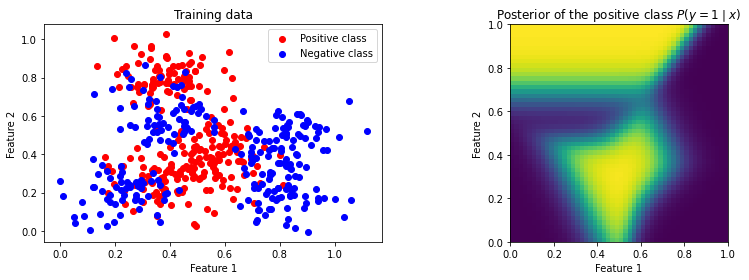

In [2]:
# Visualize the training data and the posterior
features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

In [3]:
# The weak learner we use for this classification is a decision stump of the following form:
# ℎ(𝑥;𝑠,𝜃,𝑑)=𝑠(2[𝑥𝑑≥𝜃]−1)

def evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point."""
    feature_slice = features[:, coordinate_wl]
    weak_learner_output = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_output


def evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point on a rectangular grid."""
    feature_slice = np.meshgrid(x_rng, y_rng)[coordinate_wl]
    weak_learner_on_grid = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_on_grid


In [4]:
# Find the best weak learner: at each round of AdaBoost, the samples are reweighted, thus producing 
# a new classification problem, where the samples with a larger weigth count more in the classification error. 

def find_best_weak_learner(weights, features, labels):
    """Find the best decision stump for the given weight distribution.
    
    Returns
    -------
    polarity_wl : Polarity 's' of the decision stump.
    theta_wl : Threshold 'theta' for the decision.
    coordinate_wl : Dimension 'd' along which the threshold is applied.
    err_wl : Weighted error for the decision stump.

    """
    s = [-1, 1]
    d = [0, 1]
    error = np.zeros((2, 2, npoints))
    for i in range(len(s)):
        for j in range(nfeatures):
            for k in range(npoints):
                h_x = evaluate_stump(features, s[i], features[k, j], d[j])
                error[i,j,k] = np.sum(weights * (labels != h_x))
    min_error = np.argwhere(error == np.min(error))
    polarity_wl = s[min_error[0, 0]]
    coordinate_wl = d[min_error[0, 1]]
    theta_wl = features[min_error[0, 2], coordinate_wl]
    h_wl = evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl)
    err_wl = np.sum(weights * (labels!= h_wl))
    
    return polarity_wl, theta_wl, coordinate_wl, err_wl

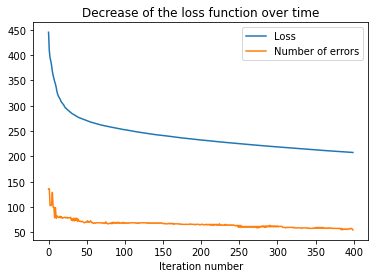

In [5]:
# Adaboost algorithm 

npoints, nfeatures = features.shape
num_rounds_boosting = 400

# Initialize arrays.
weights = np.ones(npoints) / npoints  # Weight distribution on samples
f = np.zeros((num_rounds_boosting, npoints))  # Strong classifier response at each iteration
loss = np.zeros(num_rounds_boosting)  # AdaBoost loss function
num_errors = np.zeros(num_rounds_boosting)  # Number of errors at each round

f_on_grid = 0  # Used to plot function
x_rng = y_rng = np.linspace(0, 1, 50)

for i in range(num_rounds_boosting):
    # Find best weak learner at current round of boosting.
    polarity_wl, theta_wl, coordinate_wl, err_wl = find_best_weak_learner(weights, features, labels)
    # Estimate alpha.
    alpha = 0.5 * np.log((1 - err_wl)/err_wl)
    # Reweight samples.
    h_t = evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl)
    Z_t = np.sum(weights * np.exp(-alpha * labels * h_t ))
    weights = (weights / Z_t) * np.exp(-alpha * labels * h_t)
    # Compute overall response at current round.
    f[i, :] = f[i-1, :] + alpha * h_t
    # Compute loss at current round.
    loss[i] = np.sum(np.exp(-labels*f[i, :]))
    # Keep track of the number of errors given by the final classifier.
    num_errors[i] = np.sum(labels != np.sign(f[i, :]))
    # Evaluate f on a grid to produce the images.
    weak_learner_on_grid = evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl)
    f_on_grid += alpha*weak_learner_on_grid
    # Save gridded f at specific iterations.
    if i == 10:
        f_10 = f_on_grid.copy()
    elif i == 50:
        f_50 = f_on_grid.copy()
    elif i == 100:
        f_100 = f_on_grid.copy()

# Visualize the loss function
fig, ax = plt.subplots() 
ax.plot(loss, label="Loss")
ax.plot(num_errors, label="Number of errors")
ax.legend() 
ax.set_title("Decrease of the loss function over time")
ax.set_xlabel ("Iteration number")

plt.show()

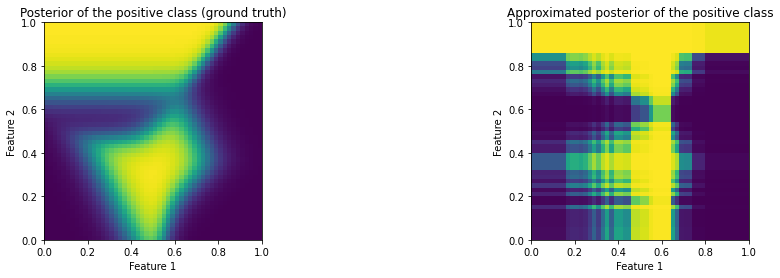

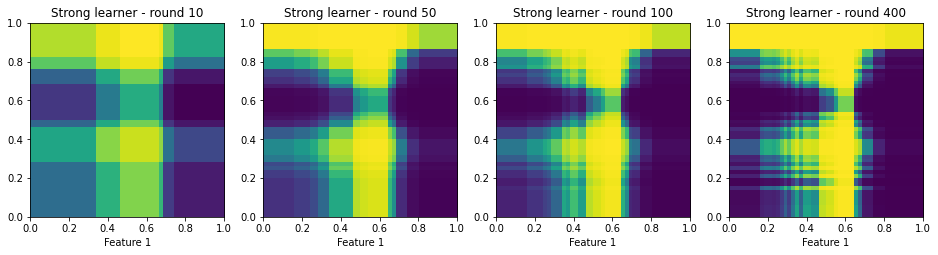

In [6]:
# Visualize the strong learner progress: it can be shown mathematically that the Adaboost strong 
# classifier's response converges to half the posterior log-ratio, which enables us to approximate
# the posterior using the strong learner's response. We can thus check below how good the response
# gets in approximating the posterior. 

approx_posterior_10 = 1 / (1 + np.exp(-2 * f_10))
approx_posterior_50 = 1 / (1 + np.exp(-2 * f_50))
approx_posterior_100 = 1 / (1 + np.exp(-2 * f_100))
approx_posterior_400 = 1 / (1 + np.exp(-2 * f_on_grid))

fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Posterior of the positive class (ground truth)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Approximated posterior of the positive class")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')

fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 4, 1)
ax.set_title("Strong learner - round 10")
ax.set_xlabel("Feature 1")
ax.imshow(approx_posterior_10, extent=[0, 1, 0, 1], origin='lower')

ax = fig.add_subplot(1, 4, 2)
ax.set_title("Strong learner - round 50")
ax.set_xlabel("Feature 1")
ax.imshow(approx_posterior_50, extent=[0, 1, 0, 1], origin='lower')

ax = fig.add_subplot(1, 4, 3)
ax.set_title("Strong learner - round 100")
ax.set_xlabel("Feature 1")
ax.imshow(approx_posterior_100, extent=[0, 1, 0, 1], origin='lower')

ax = fig.add_subplot(1, 4, 4)
ax.set_title("Strong learner - round 400")
ax.set_xlabel("Feature 1")
ax.imshow(approx_posterior_400, extent=[0, 1, 0, 1], origin='lower')

plt.show()